In [1]:
from features import *
from tqdm import tqdm_notebook
import wfdb
import pandas as pd
import numpy as np
import os
from sksurv.ensemble import RandomSurvivalForest

%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
features = []
for file in tqdm_notebook(os.listdir('examples/output')):
    features.append(pd.read_csv('examples/output/{}'.format(file), index_col=0))
features = pd.concat(features)

features.head(5)

,_emd_0_FeatureFractalDimensionHigushi,_emd_0_FeatureInterquartileRange,_emd_0_FeatureMeanAbsoluteDeviation,_emd_0_FeatureMeanEnergy,_emd_0_FeatureTeagerKaiserEnergy,_emd_0_FeatureSampleEntropy,_emd_0_FeatureStandardDeviation,a_emd_0_FeatureFractalDimensionHigushi,a_emd_0_FeatureInterquartileRange,a_emd_0_FeatureMeanAbsoluteDeviation,...,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_position,Bleeding_first_trimester,Bleeding_second_trimester,Funneling,Smoker
0,1.346133,0.004275,0.002318,8.048626e-06,3.185174e-11,0.643786,0.002832,2.117098,0.006064,0.003275,...,0,0,70,no,no,front,no,no,negative,no
0,1.348556,0.003342,0.002069,7.991406e-06,4.591723e-11,0.608230,0.002827,2.003953,0.004708,0.002924,...,0,0,70,no,no,front,no,no,negative,no
0,1.334987,0.003714,0.002239,9.277226e-06,8.733823e-11,0.611939,0.003045,2.024105,0.005255,0.003166,...,0,0,70,no,no,front,no,no,negative,no
0,1.771579,0.003009,0.001475,2.817989e-06,8.698996e-12,0.705556,0.001676,2.019968,0.004272,0.002082,...,0,0,74,no,no,end,no,no,negative,no
0,1.616242,0.001163,0.000659,6.829371e-07,3.640410e-13,0.745551,0.000826,1.956134,0.001632,0.000930,...,0,0,74,no,no,end,no,no,negative,no


In [3]:
features.shape

(894, 2121)

In [50]:
feature_groups = [
    list(filter(lambda col: 'emd' in col and 'Yule_Walker' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'Fractal' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'quartile' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'TeagerKaiser' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'MeanEnergy' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'StandardDeviation' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'SampleEntropy' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'MeanAbsoluteDeviation' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'fwh_peak_freq' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'fwh_peak_power' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'fwl_peak_freq' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'fwl_peak_power' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'gap' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'med_freq' in col, features.columns)),
    list(filter(lambda col: 'emd' in col and 'n_peaks' in col, features.columns)),
    list(filter(lambda col: 'FeaturesJanjarasjitt' in col, features.columns)),
    ['FeaturesFergusFeatureMeanAbsoluteValues'], ['FeatureFractalDimensionHigushi'], 
    ['FeaturesJager_fpeak'], ['FeaturesJager_frms'], ['FeaturesFergusFeatureWaveletLength'], 
    ['FeaturesFergusFeatureAvgAmplitudeChange'], ['FeaturesJager_fmed'],
    ['FeaturesFergusFeatureVarianceAbsoluteValue'], 
    ['FeaturesFergusFeatureSumAbsoluteValues'], ['FeatureDFA'], 
    ['FeaturesFergusFeatureMaxFractalLength'], ['FeaturesFergusFeatureLogDetector'], 
    ['FeaturesJager_sampen'],    
    list(filter(lambda col: 'TSFRESH' in col, features.columns)),
]

print(set(features.columns) - set([x for group in feature_groups for x in group]))

for group in feature_groups[:-1]:
    best, max_auc = None, 0
    best_corr, min_p = None, 1
    for channel in [1]:
        channel_features = features[features['channel'] == channel]

        early = channel_features[channel_features['Rectime'] <= 26]
        late = channel_features[channel_features['Rectime'] >= 26]
        term = channel_features[channel_features['Gestation'] >= 37]
        preterm = channel_features[channel_features['Gestation'] < 37]
        early_term = early[early['Gestation'] >= 37]
        early_preterm = early[early['Gestation'] < 37]
        late_term = late[late['Gestation'] >= 37]
        late_preterm = late[late['Gestation'] < 37]

        for feature in group:
            all_auc = roc_auc_score(channel_features['Term'], channel_features[feature])
            early_auc = roc_auc_score(early['Term'], early[feature])
            late_auc = roc_auc_score(late['Term'], late[feature])

#             p_val = spearmanr(channel_features[feature], channel_features['TimeToBirth'])[1]

            if all_auc > max_auc:
                max_auc = all_auc
                best = feature
                
        print(channel, best, roc_auc_score(channel_features['Term'], channel_features[best]),
              roc_auc_score(early['Term'], early[best]), roc_auc_score(late['Term'], late[best]))


{'Weight', 'Placental_position', 'Hypertension', 'Age', 'channel', 'Rectime', 'Smoker', 'Bleeding_second_trimester', 'Parity', 'Bleeding_first_trimester', 'id', 'TimeToBirth', 'Abortions', 'RecID', 'Term', 'Funneling', 'Diabetes', 'Gestation'}
1 aaa_emd_4_FeatureAR_Yule_Walker_5 0.6384615384615384 0.7134914751667901 0.5606601248884925
1 aaad_emd_6_FeatureFractalDimensionHigushi 0.6589068825910931 0.7531504818383987 0.5619982158786798
1 aad_emd_1_FeatureInterquartileRange 0.5941295546558705 0.6045218680504078 0.5584299732381802
1 d_emd_0_FeatureTeagerKaiserEnergy 0.5804655870445343 0.6219421793921424 0.5477252453166815
1 d_emd_0_FeatureMeanEnergy 0.572165991902834 0.6056338028169014 0.5437109723461195
1 d_emd_0_FeatureStandardDeviation 0.572165991902834 0.6056338028169014 0.5437109723461195
1 aaaa_emd_2_FeatureSampleEntropy 0.6203441295546559 0.6608598962194218 0.5718108831400535
1 aad_emd_1_FeatureMeanAbsoluteDeviation 0.5718623481781376 0.5878428465530022 0.5477252453166815
1 Features

In [246]:
cols = set()
for col in features.columns:
    if 'emd' in col:
        cols.add('_'.join(col.split('_')[3:]))

print(cols)
    
emd_featureAR_yule_walker = []
for col in features.columns:
    if 'emd' in col and 'Yule_Walker' in col:
        emd_featureAR_yule_walker.append(col)
    
emd_fractal = []
for col in features.columns:
    if 'emd' in col and 'Fractal' in col:
        emd_fractal.append(col)
        
emd_quartile = []
for col in features.columns:
    if 'emd' in col and 'quartile' in col:
        emd_quartile.append(col)
        
emd_peaks = []
for col in features.columns:
    if 'emd' in col and 'n_peaks' in col:
        emd_peaks.append(col)
        
emd_fwl_peak_freq = []
for col in features.columns:
    if 'emd' in col and 'fwl_peak_freq' in col:
        emd_fwl_peak_freq.append(col)
        
emd_fwh_peak_freq = []
for col in features.columns:
    if 'emd' in col and 'fwh_peak_freq' in col:
        emd_fwh_peak_freq.append(col)
        
print(len(emd_featureAR_yule_walker) + len(emd_fractal) + len(emd_quartile), features.shape[1])

{'FeatureFractalDimensionHigushi', 'FeatureAR_Yule_Walker_8', 'FeatureInterquartileRange', 'n_peaks', 'FeatureAR_Yule_Walker_9', 'fwl_peak_freq', 'fwh_peak_freq', 'FeatureStandardDeviation', 'gap', 'FeatureAR_Yule_Walker_2', 'FeatureAR_Yule_Walker_5', 'FeatureAR_Yule_Walker_0', 'med_freq', 'FeatureAR_Yule_Walker_7', 'FeatureAR_Yule_Walker_1', 'FeatureAR_Yule_Walker_4', 'FeatureMeanEnergy', 'FeatureTeagerKaiserEnergy', 'FeatureSampleEntropy', 'FeatureAR_Yule_Walker_6', 'FeatureAR_Yule_Walker_3', 'fwl_peak_power', 'fwh_peak_power', 'FeatureMeanAbsoluteDeviation'}
FeaturesSadiAhmed_emd_3_fwh_peak_freq
FeaturesSadiAhmed_emd_6_fwh_peak_freq
624 2123


In [250]:
emd_fractal

['_emd_0_FeatureFractalDimensionHigushi',
 'a_emd_0_FeatureFractalDimensionHigushi',
 'aa_emd_0_FeatureFractalDimensionHigushi',
 'aaa_emd_0_FeatureFractalDimensionHigushi',
 'aaaa_emd_0_FeatureFractalDimensionHigushi',
 'aaaaa_emd_0_FeatureFractalDimensionHigushi',
 'aaaaaa_emd_0_FeatureFractalDimensionHigushi',
 'd_emd_0_FeatureFractalDimensionHigushi',
 'ad_emd_0_FeatureFractalDimensionHigushi',
 'aad_emd_0_FeatureFractalDimensionHigushi',
 'aaad_emd_0_FeatureFractalDimensionHigushi',
 'aaaad_emd_0_FeatureFractalDimensionHigushi',
 '_emd_1_FeatureFractalDimensionHigushi',
 'a_emd_1_FeatureFractalDimensionHigushi',
 'aa_emd_1_FeatureFractalDimensionHigushi',
 'aaa_emd_1_FeatureFractalDimensionHigushi',
 'aaaa_emd_1_FeatureFractalDimensionHigushi',
 'aaaaa_emd_1_FeatureFractalDimensionHigushi',
 'aaaaaa_emd_1_FeatureFractalDimensionHigushi',
 'd_emd_1_FeatureFractalDimensionHigushi',
 'ad_emd_1_FeatureFractalDimensionHigushi',
 'aad_emd_1_FeatureFractalDimensionHigushi',
 'aaad_emd_1_

In [4]:
clin_features = ['id', 'channel', 'RecID', 'Gestation', 'Rectime', 'Age', 'Parity', 'Abortions', 'Weight', 'Hypertension', 'Diabetes', 'Placental_position', 'Bleeding_first_trimester', 'Bleeding_second_trimester', 'Funneling', 'Smoker']
features['Gestation'] = features['Gestation'].astype(float)
features['Rectime'] = features['Rectime'].astype(float)
features['TimeToBirth'] = features['Gestation'] - features['Rectime']
features['Term'] = features['Gestation'] >= 37

early = features[features['Rectime'] <= 26]
late = features[features['Rectime'] >= 26]
term = features[features['Gestation'] >= 37]
preterm = features[features['Gestation'] < 37]
early_term = early[early['Gestation'] >= 37]
early_preterm = early[early['Gestation'] < 37]
late_term = late[late['Gestation'] >= 37]
late_preterm = late[late['Gestation'] < 37]

In [4]:
# Generate the following statistics for each (group of) feature:
# Linear correlation with time-to-birth (possibly separately for early and late)
# Difference in population term <-> preterm (early, late, all data)
from scipy.stats import pearsonr, mannwhitneyu, ttest_ind, spearmanr
from sklearn.metrics import roc_auc_score

best, max_auc = None, 0
best_corr, min_p = None, 1
for channel in [1]:
    channel_features = features[features['channel'] == channel]
    
    early = channel_features[channel_features['Rectime'] <= 26]
    late = channel_features[channel_features['Rectime'] >= 26]
    term = channel_features[channel_features['Gestation'] >= 37]
    preterm = channel_features[channel_features['Gestation'] < 37]
    early_term = early[early['Gestation'] >= 37]
    early_preterm = early[early['Gestation'] < 37]
    late_term = late[late['Gestation'] >= 37]
    late_preterm = late[late['Gestation'] < 37]
    
    for feature in emd_featureAR_yule_walker:
        all_auc = roc_auc_score(channel_features['Term'], channel_features[feature])
        early_auc = roc_auc_score(early['Term'], early[feature])
        late_auc = roc_auc_score(late['Term'], late[feature])
        
        p_val = spearmanr(channel_features[feature], channel_features['TimeToBirth'])[1]
        
        if all_auc > max_auc:
            max_auc = all_auc
            best = feature
            
        if p_val < min_p:
            min_p = p_val
            best_corr = feature

#     for feature in emd_featureAR_yule_walker:
#         if mannwhitneyu(early_term[feature], early_preterm[feature])[1] < 0.05:
#             print(feature, mannwhitneyu(early_term[feature], early_preterm[feature]), 
#                   ttest_ind(early_term[feature], early_preterm[feature]))
    
#     for feature in emd_featureAR_yule_walker:
#         print(feature)
#         print(pearsonr(channel_features[feature], channel_features['TimeToBirth']))
#         print(pearsonr(early[feature], early['TimeToBirth']))
#         print(pearsonr(late[feature], late['TimeToBirth']))
#         print(mannwhitneyu(term[feature], preterm[feature])[1], ttest_ind(term[feature], preterm[feature])[1])
#         print(mannwhitneyu(early_term[feature], early_preterm[feature])[1], ttest_ind(early_term[feature], early_preterm[feature])[1])
#         print(mannwhitneyu(late_term[feature], late_preterm[feature])[1], ttest_ind(late_term[feature], late_preterm[feature])[1])
#         print('-'*100)

NameError: name 'emd_featureAR_yule_walker' is not defined

In [106]:
print(best, max_auc)
print(best_corr, min_p)
print(spearmanr(channel_features['aaa_emd_1_FeatureAR_Yule_Walker_0'], channel_features['TimeToBirth']))
print(pearsonr(channel_features['aaa_emd_1_FeatureAR_Yule_Walker_0'], channel_features['TimeToBirth']))

aaa_emd_4_FeatureAR_Yule_Walker_5 0.6384615384615384
aaa_emd_1_FeatureAR_Yule_Walker_0 8.90115432948427e-11
SpearmanrResult(correlation=-0.3641903814840771, pvalue=8.90115432948427e-11)
(-0.3526961291960003, 3.7192948624137006e-10)


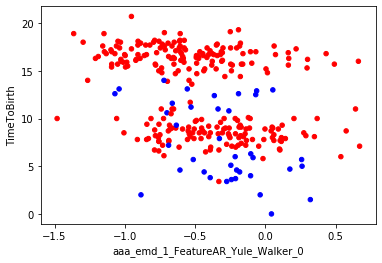

In [107]:
channel_features[['aaa_emd_1_FeatureAR_Yule_Walker_0', 'TimeToBirth']].plot(kind='scatter', x='aaa_emd_1_FeatureAR_Yule_Walker_0',
                                                                           y='TimeToBirth', c=channel_features['Term'].map({True: 'r', False: 'b'}))

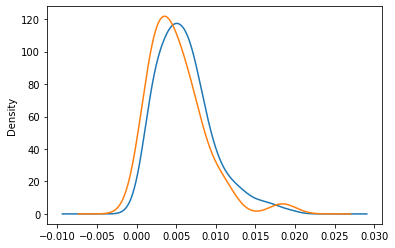

In [96]:
f, ax = plt.subplots()
channel_features[channel_features['Term']]['aad_emd_1_FeatureInterquartileRange'].plot(kind='kde', ax=ax)
channel_features[~channel_features['Term']]['aad_emd_1_FeatureInterquartileRange'].plot(kind='kde', ax=ax)
plt.show()

In [9]:
early = features[features['Rectime'] <= 26]
late = features[features['Rectime'] >= 26]

In [30]:
from scipy.stats import pearsonr
early_ch1 = early[early['channel'] == 3]
for feature in list(set(early_ch1.columns) - set(clin_features) - {'TimeToBirth'}):
    corr, p = pearsonr(early_ch1[feature], early_ch1['TimeToBirth'])
    if p < 0.05:
        print(feature, corr, p)

a_emd_0_FeatureAR_Yule_Walker_9 -0.19724681380672576 0.012142705874859326
aaaa_emd_1_FeatureSampleEntropy 0.15514282394934142 0.04940055715408708
aaa_emd_1_FeatureAR_Yule_Walker_3 0.19206514557462714 0.014654230386250957
FeaturesTSFRESH0__number_peaks__n_10 0.1811981005173756 0.02143083934560792
aaaa_emd_1_FeatureAR_Yule_Walker_4 0.21661464817568946 0.005780790807650482
FeaturesTSFRESH0__ratio_beyond_r_sigma__r_0.5 0.17873050193408738 0.023301017156854596
FeaturesTSFRESH0__fft_coefficient__coeff_33__attr_"angle" -0.18222717003466174 0.02069003211700085
aa_emd_1_FeatureSampleEntropy 0.1879110953388324 0.016984155230313165
ad_emd_1_FeatureSampleEntropy 0.19168169422160364 0.01485693609415878
aaad_emd_3_FeatureStandardDeviation -0.17276806561290461 0.028407870166895954
d_emd_9_FeatureSampleEntropy 0.19569573647650948 0.012851574075112187
aaaaa_emd_0_FeatureAR_Yule_Walker_3 0.21602786369956192 0.005917743549608605
aaa_emd_1_FeatureAR_Yule_Walker_8 0.26105879140548816 0.0008232699722139608


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


 0.16510112938611282 0.036352672822918236
a_emd_2_FeatureSampleEntropy 0.16139076836854377 0.04082617849393995
aaa_emd_1_FeatureSampleEntropy 0.25126327635031165 0.001304124297992089
FeaturesTSFRESH0__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8 -0.17123839642844005 0.02986245387711975
aaaad_emd_4_FeatureTeagerKaiserEnergy -0.19777211908023254 0.011910537316414902
FeaturesTSFRESH0__fft_coefficient__coeff_71__attr_"angle" -0.20470189915989498 0.009193324238478446
FeaturesTSFRESH0__binned_entropy__max_bins_10 0.15937550786844065 0.043443786672348585
a_emd_1_FeatureAR_Yule_Walker_3 0.16023273061512058 0.04231366860237964
aa_emd_3_FeatureAR_Yule_Walker_4 -0.1747578219375613 0.02660660555234513
FeaturesTSFRESH0__ratio_beyond_r_sigma__r_6 -0.16477003684556335 0.036734287043514495
d_emd_2_FeatureTeagerKaiserEnergy -0.2829666584199172 0.00027573561318018695
aaaa_emd_3_FeatureAR_Yule_Walker_6 0.1579529715024175 0.04537487702923266
FeaturesTSFRESH0__fft_coefficient__coeff_90__attr

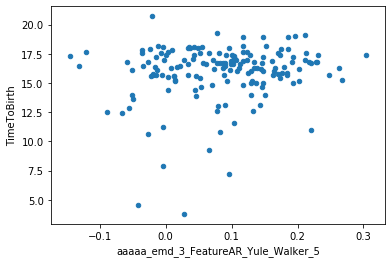

In [31]:
early_ch1[['aaaaa_emd_3_FeatureAR_Yule_Walker_5', 'TimeToBirth']].plot(kind='scatter', x='aaaaa_emd_3_FeatureAR_Yule_Walker_5', y='TimeToBirth')

In [20]:
# Create a feature matrix & multiple target vectors (preterm <-> term, ttb < 7 <-> ttb >= 7, ...)
features[['Gestation', 'Rectime', 'Age', 'Parity', 'Abortions', 'Weight']] = features[['Gestation', 'Rectime', 'Age', 'Parity', 'Abortions', 'Weight']].replace(to_replace='None', value=np.NaN)

ids = set(features['id'])
channels = set(features['channel'])
joined_features = []
for _id in tqdm_notebook(ids):
    features_id = []
    features_filtered = features[features['id'] == _id]
    for channel in channels:
        channel_features = features_filtered[features_filtered['channel'] == channel]
        col_map = {}
        for col in channel_features:
            if col not in clin_features:
                col_map[col] = '{}_ch{}'.format(col, channel)
        channel_features = channel_features.rename(columns=col_map)
        features_id.append(channel_features)
    features_id = pd.concat(features_id, axis=1)
    joined_features.append(features_id)
joined_features = pd.concat(joined_features)
joined_features = joined_features.loc[:,~joined_features.columns.duplicated()]

joined_features = pd.get_dummies(joined_features, columns=['Hypertension', 'Diabetes', 'Placental_position', 'Bleeding_first_trimester', 'Bleeding_second_trimester', 'Funneling', 'Smoker'])
for col in ['Gestation', 'Rectime', 'Age', 'Parity', 'Abortions', 'Weight']:
    joined_features[col] = joined_features[col].fillna(joined_features[col].mean())
    
for col in joined_features.columns[joined_features.isnull().sum() > 0]:
    joined_features[col] = joined_features[col].fillna(joined_features[col].mean())
    

term_preterm = joined_features['Gestation'] <= 37
ttb_10w = joined_features['TimeToBirth_ch3'] <= 10
ttb = joined_features['TimeToBirth_ch1']
feature_matrix = joined_features.drop(['TimeToBirth_ch3', 'TimeToBirth_ch2', 'TimeToBirth_ch1', 'Gestation', 
                                       'RecID', 'channel', 'id', 'Term_ch3', 'Term_ch2', 'Term_ch1'], axis=1)

print(features.shape, joined_features.shape)


(894, 2123) (298, 6351)


In [21]:
# Survival analysis to predict time-to-birth
def get_corr_features(X):
    """Get all coordinates in the X-matrix with correlation value equals 1
    (columns with equal values), excluding elements on the diagonal.

    Parameters:
    -----------
    - train_df: pd.DataFrame
        the feature matrix where correlated features need to be removed

    Returns
    -------
    - correlated_feature_pairs: list of tuples
        coordinates (row, col) where correlated features can be found
    """
    row_idx, col_idx = np.where(np.abs(X.corr()) > 0.925)
    self_corr = set([(i, i) for i in range(X.shape[1])])
    correlated_feature_pairs = set(list(zip(row_idx, col_idx))) - self_corr
    return correlated_feature_pairs


def get_uncorr_features(data):
    """Remove clusters of these correlated features, until only one feature 
    per cluster remains.

    Parameters:
    -----------
    - data: pd.DataFrame
        the feature matrix where correlated features need to be removed

    Returns
    -------
    - data_uncorr_cols: list of string
        the column names that are completely uncorrelated to eachother
    """
    X_train_corr = data.copy()
    correlated_features = get_corr_features(X_train_corr)

    corr_cols = set()
    for row_idx, col_idx in correlated_features:
        corr_cols.add(row_idx)
        corr_cols.add(col_idx)

    uncorr_cols = list(set(X_train_corr.columns) - set(X_train_corr.columns[list(corr_cols)]))
   
    col_mask = [False]*X_train_corr.shape[1]
    for col in corr_cols:
        col_mask[col] = True
    X_train_corr = X_train_corr.loc[:, col_mask]
  
    correlated_features = get_corr_features(X_train_corr)

    while correlated_features:
        corr_row, corr_col = correlated_features.pop()
        col_mask = [True]*X_train_corr.shape[1]
        col_mask[corr_row] = False
        X_train_corr = X_train_corr.loc[:, col_mask]
        correlated_features = get_corr_features(X_train_corr)

    data_uncorr_cols = list(set(list(X_train_corr.columns) + uncorr_cols))

    return data_uncorr_cols

def remove_features(data):
    """Remove all correlated features and columns with only a single value.

    Parameters:
    -----------
    - data: pd.DataFrame
        the feature matrix where correlated features need to be removed

    Returns
    -------
    - useless_cols: list of string
        list of column names that have no predictive value
    """
    single_cols = list(data.columns[data.nunique() == 1])

    uncorr_cols = get_uncorr_features(data)
    corr_cols = list(set(data.columns) - set(uncorr_cols))

    useless_cols = list(set(single_cols + corr_cols))

    print('Removing {} features'.format(len(useless_cols)))

    return useless_cols

print(sum(feature_matrix.std(axis=0) < 0.05))
feature_matrix = feature_matrix.loc[:, feature_matrix.std(axis=0) >= 0.05]
useless_features = remove_features(feature_matrix)

feature_matrix = feature_matrix.drop(useless_features, axis=1)
feature_matrix.shape

4290
Removing 488 features


(298, 1563)

In [81]:
# Let's create a sklearn pipeline
import smote_variants as sv
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import warnings; warnings.filterwarnings('ignore')

class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].classifier.best_estimator_.coef_
        return self

pipeline = PipelineRFE([
    (
        'scale', 
        StandardScaler()
    ),
    (
        'sampling+model', 
        sv.OversamplingClassifier(
            sv.Safe_Level_SMOTE(), 
            GridSearchCV(
                LogisticRegression(), 
                {'penalty': ['l1', 'l2'], 'C': [10**i for i in range(-4, 5)]},
                scoring='roc_auc'
            )
        )
    )
])

y = feature_matrix['Rectime'] + ttb >= 37
if 'duration' in feature_matrix.columns:
    feature_matrix = feature_matrix.drop('duration', axis=1)
for col in feature_matrix.columns:
    if 'Term' in col:
        feature_matrix = feature_matrix.drop(col, axis=1)
    
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, y, random_state=2020, stratify=y)
clf = RFECV(pipeline, cv=3, step=100, scoring='roc_auc')
clf.fit(X_train, y_train)

print(confusion_matrix(y_test, clf.predict(X_test)))

2019-12-24 11:31:58,512:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1568 features.


2019-12-24 11:32:06,525:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1318 features.


2019-12-24 11:32:13,274:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1068 features.


2019-12-24 11:32:20,258:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 818 features.


2019-12-24 11:32:26,933:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 568 features.


2019-12-24 11:32:33,073:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 318 features.


2019-12-24 11:32:38,441:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 68 features.


2019-12-24 11:32:42,715:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:32:42,864:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1568 features.


2019-12-24 11:32:49,032:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1318 features.


2019-12-24 11:32:55,680:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1068 features.


2019-12-24 11:33:01,606:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 818 features.


2019-12-24 11:33:04,499:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 568 features.


2019-12-24 11:33:06,965:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 318 features.


2019-12-24 11:33:12,772:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 68 features.


2019-12-24 11:33:13,683:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:33:13,833:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1568 features.


2019-12-24 11:33:24,592:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1318 features.


2019-12-24 11:33:34,272:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1068 features.


2019-12-24 11:33:41,859:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 818 features.


2019-12-24 11:33:48,157:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 568 features.


2019-12-24 11:33:54,380:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 318 features.


2019-12-24 11:33:59,892:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 68 features.


2019-12-24 11:34:02,148:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1568 features.


2019-12-24 11:34:02,825:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:34:19,337:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1318 features.


2019-12-24 11:34:31,793:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 1068 features.


2019-12-24 11:34:43,131:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 818 features.


2019-12-24 11:34:53,029:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 568 features.


2019-12-24 11:34:59,465:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting estimator with 318 features.


2019-12-24 11:35:05,036:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:35:11,215:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[[ 4  6]
 [15 50]]


In [82]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

0.5569230769230769


In [80]:
# list(feature_matrix.columns[clf.support_])
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [84]:
# Let's create a sklearn pipeline
import smote_variants as sv
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].classifier.best_estimator_.coef_
        return self

X = feature_matrix.reset_index(drop=True)

skf = StratifiedKFold(n_splits=5)

scores = {}

for sampling_alg in sv.get_n_quickest_oversamplers(50):
    pipeline = PipelineRFE([
        (
            'scale', 
            StandardScaler()
        ),
        (
            'sampling+model', 
            sv.OversamplingClassifier(
                sampling_alg(),
                GridSearchCV(
                    LogisticRegression(), 
                    {'penalty': ['l1', 'l2'], 'C': [10**i for i in range(-4, 5)]},
                    scoring='roc_auc'
                )
            )
        )
    ])
    
    preds = np.zeros((len(X), 2))
    for fold_ix, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train = X.iloc[train_idx, :]
        X_test = X.iloc[test_idx, :]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        clf = RFECV(pipeline, cv=3, step=100, scoring='roc_auc')
        clf.fit(X_train.values, y_train.values)
        
        preds[test_idx, 0] = fold_ix
        preds[test_idx, 1] = clf.predict_proba(X_test.values)[:, 1]
        
    preds = pd.DataFrame(preds, columns=['fold', 'prediction'])
    preds.to_csv('output/{}_predictions.csv')

2019-12-24 11:39:10,426:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:39:12,977:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:39:15,286:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:39:17,608:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:39:19,779:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:39:21,977:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:39:23,727:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:39:25,314:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:39:26,691:INFO:SPY: Running sampling via ('SPY', "{'n_neig

2019-12-24 11:41:08,904:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:41:09,525:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:41:09,834:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:41:10,068:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:41:10,244:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:41:13,247:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:41:15,636:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:41:18,045:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:41:20,006:INFO:SPY: Running sampling via ('SPY', "{'n_neig

2019-12-24 11:43:05,814:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:43:06,936:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:43:07,951:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:43:08,840:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:43:09,570:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:43:10,200:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:43:10,495:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:43:10,723:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:43:10,863:INFO:SPY: Running sampling via ('SPY', "{'n_neig

2019-12-24 11:44:55,915:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:44:56,598:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:44:57,578:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:44:57,904:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:44:58,184:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:44:58,348:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:45:01,010:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:45:03,813:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:45:06,947:INFO:SPY: Running sampling via ('SPY', "{'n_neig

2019-12-24 11:46:50,421:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:46:50,671:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:46:50,820:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:46:53,649:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:46:56,099:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:46:58,534:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:47:01,174:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:47:03,542:INFO:SPY: Running sampling via ('SPY', "{'n_neighbors': 5, 'threshold': 0.5, 'n_jobs': 1}")
2019-12-24 11:47:05,721:INFO:SPY: Running sampling via ('SPY', "{'n_neig

<class 'smote_variants._smote_variants.SPY'> 0.5169230769230769 0.011347131639745068


2019-12-24 11:47:42,671:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:47:47,665:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:47:52,683:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:47:57,653:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:48:01,581:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:48:05,756:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:48:09,073:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:48:12,440:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:48

2019-12-24 11:50:55,125:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:50:56,405:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:50:57,498:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:50:58,238:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:50:58,598:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:50:58,744:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:51:02,832:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:51:06,888:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:51

2019-12-24 11:54:01,415:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:54:03,048:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:54:04,955:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:54:05,997:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:54:07,743:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:54:08,071:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:54:08,225:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:54:12,412:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:54

2019-12-24 11:58:00,758:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:58:02,675:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:58:04,648:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:58:06,250:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:58:07,596:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:58:08,599:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:58:09,020:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:58:09,165:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 11:58

2019-12-24 12:01:08,156:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:01:10,909:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:01:13,569:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:01:16,065:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:01:18,359:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:01:20,021:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:01:21,250:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:01:21,573:INFO:OUPS: Running sampling via ('OUPS', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:01

<class 'smote_variants._smote_variants.OUPS'> 0.576923076923077 0.04803351886871541


2019-12-24 12:05:33,866:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:05:37,510:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:05:40,975:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:05:44,299:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:05:47,341:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:05:50,317:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:05:52,749:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:05:55,003:INFO:SMOTE_D: Run

2019-12-24 12:08:08,063:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:08:11,004:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:08:13,048:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:08:14,162:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:08:15,537:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:08:16,807:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:08:20,338:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:08:24,525:INFO:SMOTE_D: Run

2019-12-24 12:10:35,841:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:10:40,353:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:10:45,401:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:10:49,746:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:10:53,602:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:10:57,339:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:11:00,111:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:11:02,986:INFO:SMOTE_D: Run

2019-12-24 12:13:09,549:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:13:10,430:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:13:11,136:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:13:11,431:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:13:11,581:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:13:17,649:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:13:23,024:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:13:28,402:INFO:SMOTE_D: Run

2019-12-24 12:15:42,775:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:15:43,949:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:15:44,978:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:15:45,761:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:15:46,389:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:15:46,640:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:15:46,764:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:15:52,221:INFO:SMOTE_D: Run

2019-12-24 12:17:56,904:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:17:57,481:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:17:57,741:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:17:57,881:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:18:03,301:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:18:08,790:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")


<class 'smote_variants._smote_variants.SMOTE_D'> 0.5793846153846154 0.018832176920737662


2019-12-24 12:18:12,382:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:18:15,729:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:18:18,937:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:18:22,005:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:18:25,018:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:18:27,899:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:18:30,431:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:18:33,016:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proport

2019-12-24 12:20:37,450:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:20:38,567:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:20:39,569:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:20:39,853:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:20:40,105:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:20:43,731:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:20:47,427:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:20:50,907:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proport

2019-12-24 12:23:00,308:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:23:03,082:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:23:05,877:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:23:08,367:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:23:10,481:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:23:12,257:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:23:14,152:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:23:15,460:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proport

2019-12-24 12:25:21,180:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:25:25,657:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:25:30,376:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:25:34,800:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:25:39,039:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:25:42,238:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:25:45,296:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:25:48,339:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proport

2019-12-24 12:27:50,389:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:27:55,537:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:28:00,709:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:28:05,621:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:28:10,810:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:28:15,623:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:28:19,617:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:28:23,316:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proport

2019-12-24 12:30:32,158:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:30:32,883:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:30:33,438:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:30:33,704:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:30:33,838:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:30:39,253:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:30:44,423:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:30:49,472:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proport

<class 'smote_variants._smote_variants.NT_SMOTE'> 0.5766153846153846 0.03560998463797984


2019-12-24 12:31:27,412:INFO:Gazzah: Removing 42 majority samples
2019-12-24 12:31:29,990:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:31:29,996:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:31:30,077:INFO:Gazzah: Removing 45 majority samples
2019-12-24 12:31:32,309:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:31:32,311:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:31:32,383:INFO:Gazzah: Removing 46 majority samples
2019-12-24 12:31:3

2019-12-24 12:32:00,063:INFO:Gazzah: Removing 44 majority samples
2019-12-24 12:32:02,525:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:32:02,526:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:32:02,614:INFO:Gazzah: Removing 46 majority samples
2019-12-24 12:32:05,177:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:32:05,178:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:32:05,255:INFO:Gazzah: Removing 47 majority samples
2019-12-24 12:32:0

2019-12-24 12:32:28,465:INFO:Gazzah: Removing 47 majority samples
2019-12-24 12:32:30,998:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:32:30,999:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:32:31,066:INFO:Gazzah: Removing 45 majority samples
2019-12-24 12:32:33,378:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:32:33,391:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:32:33,466:INFO:Gazzah: Removing 46 majority samples
2019-12-24 12:32:3

2019-12-24 12:33:00,388:INFO:Gazzah: Removing 72 majority samples
2019-12-24 12:33:03,640:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:33:03,643:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:33:03,744:INFO:Gazzah: Removing 71 majority samples
2019-12-24 12:33:06,846:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:33:06,847:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:33:06,939:INFO:Gazzah: Removing 71 majority samples
2019-12-24 12:33:0

2019-12-24 12:33:37,261:INFO:Gazzah: Removing 47 majority samples
2019-12-24 12:33:39,343:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:33:39,345:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:33:39,442:INFO:Gazzah: Removing 44 majority samples
2019-12-24 12:33:41,712:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:33:41,713:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:33:41,778:INFO:Gazzah: Removing 43 majority samples
2019-12-24 12:33:4

2019-12-24 12:34:06,766:INFO:Gazzah: Removing 45 majority samples
2019-12-24 12:34:08,312:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:34:08,319:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:34:08,365:INFO:Gazzah: Removing 44 majority samples
2019-12-24 12:34:09,740:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:34:09,746:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:34:09,792:INFO:Gazzah: Removing 41 majority samples
2019-12-24 12:34:1

2019-12-24 12:34:34,095:INFO:Gazzah: Removing 45 majority samples
2019-12-24 12:34:35,517:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:34:35,523:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:34:35,575:INFO:Gazzah: Removing 47 majority samples
2019-12-24 12:34:37,346:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:34:37,348:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:34:37,432:INFO:Gazzah: Removing 46 majority samples
2019-12-24 12:34:3

2019-12-24 12:35:07,690:INFO:Gazzah: Removing 70 majority samples
2019-12-24 12:35:10,226:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:35:10,230:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:35:10,308:INFO:Gazzah: Removing 70 majority samples
2019-12-24 12:35:12,183:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:35:12,189:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:35:12,258:INFO:Gazzah: Removing 66 majority samples
2019-12-24 12:35:1

2019-12-24 12:35:36,551:INFO:Gazzah: Removing 42 majority samples
2019-12-24 12:35:37,946:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:35:37,948:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:35:38,018:INFO:Gazzah: Removing 41 majority samples
2019-12-24 12:35:39,034:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:35:39,040:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:35:39,105:INFO:Gazzah: Removing 42 majority samples
2019-12-24 12:35:4

2019-12-24 12:36:02,370:INFO:Gazzah: Removing 42 majority samples
2019-12-24 12:36:03,740:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:36:03,746:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:36:03,789:INFO:Gazzah: Removing 37 majority samples
2019-12-24 12:36:05,635:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:36:05,640:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:36:05,736:INFO:Gazzah: Removing 38 majority samples
2019-12-24 12:36:0

2019-12-24 12:36:34,139:INFO:Gazzah: Removing 46 majority samples
2019-12-24 12:36:35,053:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:36:35,058:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:36:35,120:INFO:Gazzah: Removing 49 majority samples
2019-12-24 12:36:35,837:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:36:35,838:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:36:35,936:INFO:Gazzah: Removing 41 majority samples
2019-12-24 12:36:3

2019-12-24 12:37:12,722:INFO:Gazzah: Removing 58 majority samples
2019-12-24 12:37:14,245:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:37:14,247:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:37:14,381:INFO:Gazzah: Removing 55 majority samples
2019-12-24 12:37:15,736:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:37:15,741:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:37:15,969:INFO:Gazzah: Removing 54 majority samples
2019-12-24 12:37:1

2019-12-24 12:37:45,567:INFO:Gazzah: Removing 39 majority samples
2019-12-24 12:37:46,565:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:37:46,566:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:37:46,680:INFO:Gazzah: Removing 33 majority samples
2019-12-24 12:37:47,511:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:37:47,513:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:37:47,598:INFO:Gazzah: Removing 35 majority samples
2019-12-24 12:37:4

2019-12-24 12:38:22,917:INFO:Gazzah: Removing 36 majority samples
2019-12-24 12:38:24,472:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:38:24,479:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:38:24,549:INFO:Gazzah: Removing 42 majority samples
2019-12-24 12:38:25,452:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:38:25,458:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:38:25,499:INFO:Gazzah: Removing 43 majority samples
2019-12-24 12:38:2

2019-12-24 12:39:02,999:INFO:Gazzah: Removing 39 majority samples
2019-12-24 12:39:04,129:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:39:04,134:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:39:04,168:INFO:Gazzah: Removing 49 majority samples
2019-12-24 12:39:04,635:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:39:04,638:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:39:04,648:INFO:Gazzah: Removing 36 majority samples
2019-12-24 12:39:0

2019-12-24 12:39:58,636:INFO:Gazzah: Removing 50 majority samples
2019-12-24 12:39:59,251:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:39:59,259:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:39:59,297:INFO:Gazzah: Removing 50 majority samples
2019-12-24 12:40:00,127:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:40:00,129:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:40:00,254:INFO:Gazzah: Removing 42 majority samples
2019-12-24 12:40:0

2019-12-24 12:40:44,496:INFO:Gazzah: Removing 25 majority samples
2019-12-24 12:40:44,841:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:40:44,842:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:40:44,918:INFO:Gazzah: Removing 45 majority samples
2019-12-24 12:40:49,824:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:40:49,833:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:40:49,925:INFO:Gazzah: Removing 48 majority samples
2019-12-24 12:40:5

2019-12-24 12:41:30,059:INFO:Gazzah: Removing 46 majority samples
2019-12-24 12:41:34,022:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:41:34,025:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:41:34,144:INFO:Gazzah: Removing 46 majority samples
2019-12-24 12:41:37,439:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:41:37,457:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:41:37,574:INFO:Gazzah: Removing 47 majority samples
2019-12-24 12:41:4

2019-12-24 12:42:11,133:INFO:Gazzah: Removing 72 majority samples
2019-12-24 12:42:16,085:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:42:16,089:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:42:16,203:INFO:Gazzah: Removing 73 majority samples
2019-12-24 12:42:21,524:INFO:Gazzah: Running sampling via ('Gazzah', "{'proportion': 1.0, 'n_components': 2, 'n_jobs': 1, 'random_state': None}")
2019-12-24 12:42:21,532:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': <module 'numpy.random' from '/usr/local/lib/python3.6/dist-packages/numpy/random/__init__.py'>}")
2019-12-24 12:42:21,635:INFO:Gazzah: Removing 72 majority samples
2019-12-24 12:42:2

<class 'smote_variants._smote_variants.Gazzah'> 0.5030769230769232 0.03076923076923075


2019-12-24 12:43:03,145:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:43:09,615:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:43:15,669:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:43:21,131:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:43:26,162:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:43:31,831:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:43:36,700:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:43:41,651:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:43:46,462:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24

2019-12-24 12:48:28,656:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:48:32,077:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:48:35,295:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:48:37,966:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:48:39,995:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:48:41,578:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:48:42,973:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:48:43,992:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:48:44,361:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24

2019-12-24 12:53:33,050:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:53:33,515:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:53:33,865:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:53:40,611:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:53:47,957:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:53:53,439:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:54:00,457:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:54:06,676:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:54:11,487:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24

2019-12-24 12:59:20,969:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:59:23,007:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:59:25,356:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:59:27,115:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:59:28,449:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:59:29,202:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:59:29,608:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:59:38,233:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 12:59:46,363:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24

2019-12-24 13:04:26,442:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 13:04:31,760:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 13:04:36,816:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 13:04:42,129:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 13:04:47,225:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 13:04:51,750:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 13:04:55,750:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 13:04:59,085:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24 13:05:02,431:INFO:ROSE: Running sampling via ('ROSE', "{'proportion': 1.0, 'random_state': None}")
2019-12-24

<class 'smote_variants._smote_variants.ROSE'> 0.579076923076923 0.058741032300595845


2019-12-24 13:06:32,848:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:06:39,502:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:06:45,796:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:06:50,472:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:06:56,238:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:07:01,738:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}"

2019-12-24 13:09:30,319:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:09:39,336:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:09:47,444:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:09:57,525:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:10:05,063:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:10:13,119:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}"

2019-12-24 13:13:03,624:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:13:03,922:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:13:10,173:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:13:16,031:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:13:22,074:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:13:27,526:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}"

2019-12-24 13:16:28,742:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:16:29,209:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:16:29,491:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:16:35,855:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:16:42,610:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:16:48,939:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}"

2019-12-24 13:19:30,164:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:19:35,413:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:19:40,299:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:19:44,700:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:19:49,182:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:19:53,750:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}"

2019-12-24 13:22:06,771:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:22:15,195:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:22:23,105:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:22:30,985:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:22:38,114:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:22:45,370:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}"

2019-12-24 13:25:21,899:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:25:22,979:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:25:23,474:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:25:23,890:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:25:29,983:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:25:35,860:INFO:NDO_sampling: Running sampling via ('NDO_sampling', "{'proportion': 1.0, 'n_neighbors': 5, 'T': 0.5, 'n_jobs': 1, 'random_state': None}"

<class 'smote_variants._smote_variants.NDO_sampling'> 0.5975384615384616 0.0780871914429993


2019-12-24 13:27:51,115:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:27:56,370:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:28:01,572:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:28:05,513:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:28:10,092:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:28:14,080:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:28:17,781:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")

2019-12-24 13:31:16,046:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:31:19,924:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:31:23,904:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:31:27,271:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:31:30,139:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:31:32,297:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2019-12-24 13:31:34,639:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")

KeyboardInterrupt: 

In [21]:
# ISMOTE scores 0.59
scores

{smote_variants._smote_variants.SPY: 0.5254807692307693,
 smote_variants._smote_variants.OUPS: 0.5440934065934065,
 smote_variants._smote_variants.SMOTE_D: 0.533173076923077,
 smote_variants._smote_variants.NT_SMOTE: 0.5263049450549451,
 smote_variants._smote_variants.Gazzah: 0.474793956043956,
 smote_variants._smote_variants.ROSE: 0.5639423076923078,
 smote_variants._smote_variants.NDO_sampling: 0.5572802197802197,
 smote_variants._smote_variants.SMOTE: 0.5461538461538462,
 smote_variants._smote_variants.Borderline_SMOTE1: 0.5474587912087913,
 smote_variants._smote_variants.Borderline_SMOTE2: 0.5288461538461539,
 smote_variants._smote_variants.ISMOTE: 0.5860576923076923,
 smote_variants._smote_variants.SMMO: 0.5254807692307693,
 smote_variants._smote_variants.SMOTE_OUT: 0.5576923076923077,
 smote_variants._smote_variants.SN_SMOTE: 0.5473214285714285,
 smote_variants._smote_variants.distance_SMOTE: 0.5250686813186813,
 smote_variants._smote_variants.Selected_SMOTE: 0.5407280219780219,


In [9]:
from lifelines import CoxPHFitter, WeibullAFTFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cph = CoxPHFitter(penalizer=10.0)
feature_matrix['duration'] = ttb

train_feature_matrix, test_feature_matrix, _, _ = train_test_split(feature_matrix, feature_matrix['duration'], random_state=2020,
                                                                   stratify=(feature_matrix['Rectime'] + feature_matrix['duration']) >= 37,
                                                                   test_size=0.2)
# scaler = StandardScaler()
# scaled_train_features = pd.DataFrame(scaler.fit_transform(train_feature_matrix),
#                                      columns=train_feature_matrix.columns,
#                                      index=train_feature_matrix.index)
# scaled_train_features['duration'] = train_feature_matrix['duration']

# cph.fit(train_feature_matrix, duration_col='duration', show_progress=True, step_size=0.25)

In [65]:
scaled_test_features = pd.DataFrame(scaler.transform(test_feature_matrix),
                                     columns=test_feature_matrix.columns,
                                     index=test_feature_matrix.index)
scaled_test_features['duration'] = test_feature_matrix['duration']

term_preds = []
preterm_preds = []
for i, row in scaled_test_features.iterrows():
    rectime_index = list(scaled_test_features.columns).index('Rectime')
    rectime = scaler.inverse_transform([row])[0][rectime_index]
    time_to_term = 37 - rectime
    closest_col, min_dist = None, float('inf')
    for col in cph.predict_survival_function(row).T.columns:
        if abs(col - time_to_term) < min_dist:
            min_dist = abs(col - time_to_term)
            closest_col = col
    preds = cph.predict_survival_function(row).T
    if rectime + row['duration'] >= 37:
        term_preds.append(cph.predict_survival_function(row).T[closest_col].iloc[0])
    else:
        preterm_preds.append(cph.predict_survival_function(row).T[closest_col].iloc[0])

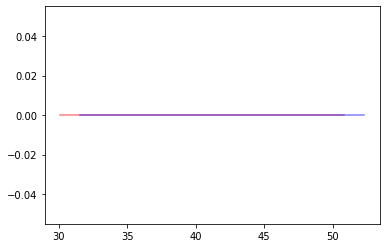

In [64]:
term_cntr = 0
preterm_cntr = 0

f, ax = plt.subplots()

for i, row in scaled_test_features.iterrows():
    rectime_index = list(scaled_test_features.columns).index('Rectime')
    rectime = scaler.inverse_transform([row])[0][rectime_index]
    time_to_term = 37 - rectime
    closest_col, min_dist = None, float('inf')
    for col in cph.predict_survival_function(row).T.columns:
        if abs(col - time_to_term) < min_dist:
            min_dist = abs(col - time_to_term)
            closest_col = col
    preds = cph.predict_survival_function(row).T
#     print(preds)
    if rectime + row['duration'] >= 37 and term_cntr < 1:
        ax.plot(preds.columns + rectime, preds.iloc[0].values, c='r', alpha=0.5)
        term_cntr += 1
        
    elif preterm_cntr < 1:
        ax.plot(preds.columns + rectime, preds.iloc[0].values, c='b', alpha=0.5)
        preterm_cntr += 1
plt.show()

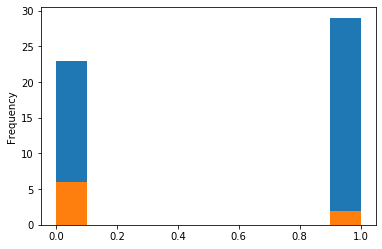

0.6790865384615385

In [66]:
f, ax= plt.subplots()
pd.Series(term_preds).plot(kind='hist', ax=ax)
pd.Series(preterm_preds).plot(kind='hist', ax=ax)
plt.show()

roc_auc_score([1]*len(term_preds) + [0]*len(preterm_preds), term_preds + preterm_preds)
#6384615384615385

In [210]:
cph.check_assumptions(train_feature_matrix.reset_index(drop=True))

Proportional hazard assumption looks okay.


In [23]:
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sklearn.model_selection import train_test_split
feature_matrix['duration'] = ttb
train_feature_matrix, test_feature_matrix, _, _ = train_test_split(feature_matrix, feature_matrix['duration'], random_state=1337,
                                                                   stratify=(feature_matrix['Rectime'] + feature_matrix['duration']) >= 37,
                                                                   test_size=0.2)

clf = RandomSurvivalForest(n_estimators=250, min_samples_split=5)
y_train = train_feature_matrix[['duration']]
y_train['event'] = True
y_train['event'] = y_train['event'].astype(int)
y_train['duration'] = y_train['duration'].astype(float) * 7
y = np.array([(x[0], x[1]) for x in y_train[['event', 'duration']].values], dtype=[('bool', np.bool),('duration', 'd')])
clf.fit(train_feature_matrix.drop('duration', axis=1), y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, min_samples_leaf=3,
                     min_samples_split=5, min_weight_fraction_leaf=0.0,
                     n_estimators=250, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [13]:
train_preterm = train_feature_matrix['Rectime'].values * 7 + train_feature_matrix['duration'] <= 37*7
# Let's append the samples 5 times (total weight of 6)
train_feature_matrix_aug = [train_feature_matrix]
for _ in range(5):
    train_feature_matrix_aug.append(train_feature_matrix.loc[train_preterm, :])
train_feature_matrix_aug = pd.concat(train_feature_matrix_aug)

clf = RandomSurvivalForest(n_estimators=250, min_samples_split=5)
y_train = train_feature_matrix_aug[['duration']]
y_train['event'] = True
y_train['event'] = y_train['event'].astype(int)
y_train['duration'] = y_train['duration'].astype(float) * 7
y = np.array([(x[0], x[1]) for x in y_train[['event', 'duration']].values], dtype=[('bool', np.bool),('duration', 'd')])
clf.fit(train_feature_matrix_aug.drop('duration', axis=1), y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

KeyboardInterrupt: 

In [24]:
term_preds = []
preterm_preds = []
for i, row in test_feature_matrix.iterrows():
#     rectime_index = list(scaled_test_features.columns).index('Rectime')
#     rectime = scaler.inverse_transform([row])[0][rectime_index]
    rectime = row['Rectime']
    time_to_term = (37 - rectime) * 7
    closest_col, min_dist = None, float('inf')
    for col, time in enumerate(clf.event_times_):
        if abs(time - time_to_term) < min_dist:
            min_dist = abs(time - time_to_term)
            closest_col = col
#     print(rectime * 7 + row['duration'] >= 37 * 7, rectime, row['duration'], time_to_term, clf.event_times_[closest_col], clf.predict_survival_function([row.drop('duration')])[0, closest_col])
    if rectime * 7 + row['duration'] * 7 >= 37 * 7:
        term_preds.append(clf.predict_survival_function([row.drop('duration')])[0, closest_col])
    else:
        preterm_preds.append(clf.predict_survival_function([row.drop('duration')])[0, closest_col])

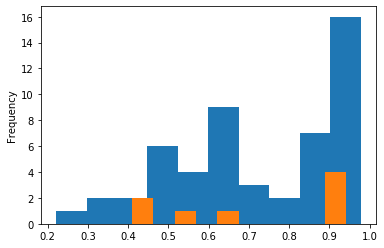

0.5048076923076923

In [25]:
from sklearn.metrics import roc_auc_score
f, ax= plt.subplots()
pd.Series(term_preds).plot(kind='hist', ax=ax)
pd.Series(preterm_preds).plot(kind='hist', ax=ax)
plt.show()

roc_auc_score([1]*len(term_preds) + [0]*len(preterm_preds), term_preds + preterm_preds)
#6384615384615385

In [ ]:
# clf.predict()

surv = clf.predict_survival_function(test_feature_matrix.drop('duration', axis=1))

for i, s in enumerate(surv):
    plt.step(clf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.grid(True)
# plt.legend()

In [12]:
train_feature_matrix.shape, test_feature_matrix.shape

((238, 1570), (60, 1570))

In [19]:
for col in train_feature_matrix.columns:
    if 'Gestation' in col:
        print(col)

In [52]:
train_feature_matrix, test_feature_matrix, _, _ = train_test_split(feature_matrix, feature_matrix['duration'], random_state=1337,
                                                                   stratify=(feature_matrix['Rectime'] + feature_matrix['duration']) >= 37,
                                                                   test_size=0.2)

clf = RandomSurvivalForest(n_estimators=250, min_samples_split=5)
y_train = train_feature_matrix[['duration']]
y_train['event'] = True
y_train['event'] = y_train['event'].astype(int)
y_train['duration'] = y_train['duration'].astype(float) * 7
y = np.array([(x[0], x[1]) for x in y_train[['event', 'duration']].values], dtype=[('bool', np.bool),('duration', 'd')])
clf.fit(train_feature_matrix.drop('duration', axis=1), y)

array([( True,  35. ), ( True, 114.8), ( True,  55.3), ( True,  62.3),
       ( True,  95.2), ( True, 119. ), ( True, 114.1), ( True, 107.8),
       ( True, 127.4), ( True, 112. ), ( True,  70. ), ( True,  50.4),
       ( True, 135.1), ( True, 111.3), ( True, 105. ), ( True, 126.7),
       ( True,  49. ), ( True, 112.7), ( True,  63. ), ( True,  77. ),
       ( True, 123.2), ( True,  56.7), ( True, 100.8), ( True, 107.8),
       ( True, 119.7), ( True,  54.6), ( True, 114.8), ( True,  61.6),
       ( True, 126. ), ( True, 105. ), ( True,  64.4), ( True, 109.9),
       ( True,  32.2), ( True,  46.9), ( True, 112.7), ( True,  14. ),
       ( True, 116.2), ( True, 123.9), ( True, 110.6), ( True, 119. ),
       ( True,  65.1), ( True, 112. ), ( True,  59.5), ( True,  53.9),
       ( True, 115.5), ( True,  77. ), ( True,  54.6), ( True, 109.2),
       ( True, 123.2), ( True, 123.2), ( True,  53.2), ( True, 118.3),
       ( True, 116.9), ( True, 123.2), ( True,  14. ), ( True,  77. ),
      

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix
import warnings; warnings.filterwarnings('ignore')

skf = StratifiedKFold(n_splits=5)
for train_ix, test_ix in skf.split(feature_matrix, term_preterm):
    X_train = feature_matrix.iloc[train_ix, :]
    X_test = feature_matrix.iloc[test_ix, :]
    y_train = term_preterm.iloc[train_ix]
    y_test = term_preterm.iloc[test_ix]
    
    clf = GridSearchCV(LogisticRegression(), {'penalty': ['l1', 'l2'], 'C': [10**i for i in range(-4, 5)]})
    clf.fit(X_train, y_train)
    
    print(confusion_matrix(y_test, clf.predict(X_test)))

[[52  0]
 [ 9  0]]
[[51  0]
 [ 9  0]]
[[51  0]
 [ 8  0]]
[[51  0]
 [ 8  0]]
[[51  0]
 [ 8  0]]


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings; warnings.filterwarnings('ignore')

skf = StratifiedKFold(n_splits=5)
for train_ix, test_ix in skf.split(feature_matrix, ttb_10w):
    X_train = feature_matrix.iloc[train_ix, :]
    X_test = feature_matrix.iloc[test_ix, :]
    y_train = ttb_10w.iloc[train_ix]
    y_test = ttb_10w.iloc[test_ix]
    
    clf = GridSearchCV(LogisticRegression(), {'penalty': ['l1', 'l2'], 'C': [10**i for i in range(-4, 5)]})
    clf.fit(X_train, y_train)
    
    print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

[[22 11]
 [ 9 18]]


KeyboardInterrupt: 

# Load data

In [2]:
def process_header_file(file):
    # The clinical variables are added as comments in the
    # .hea file. Extract them from that file.
    start_idx = 0
    with open(file, 'r') as ifp:
        lines = ifp.readlines()
        for line_idx, line in enumerate(lines):
            if line.startswith('#'):
                start_idx = line_idx
                break
        
        names = []
        values = []
        for line in lines[start_idx+1:]:
            _, name, value = line.split()
            names.append(name)
            values.append(value)
            
        return names, values

In [3]:
signals = []
gestations = []
remaining_durations = []
ids = []

for file in tqdm_notebook(set(map(lambda x: x.split('.')[0], os.listdir('data/tpehgdb')))):
    ids.append(file)
    file_path = 'data/tpehgdb/{}'.format(file)

    record = wfdb.rdrecord(file_path)
    
    clin_names, clin_values = process_header_file(file_path + '.hea')
    gestation = float(clin_values[1])
    rectime = float(clin_values[2])
    remaining_duration = gestation - rectime
    
    signal_ch1 = record.p_signal[:, 2]
    signal_ch2 = record.p_signal[:, 6]
    signal_ch3 = record.p_signal[:, 10]
    
    if len(signal_ch1) < 33000: # Faulty signal
        continue
    
    signals.append([signal_ch1, signal_ch2, signal_ch3])
    gestations.append(gestation)
    remaining_durations.append(remaining_duration)

# Peak Frequency

In [105]:
def peak_freq(data, fs):
    ps = np.abs(np.fft.fft(data))**2
    M = len(ps)
    freqs = np.fft.fftfreq(M, d=1/fs)
    
    mask = freqs >= 0
    freqs = freqs[mask]
    ps = ps[mask]
    
    return np.abs(freqs[np.argmax(ps)])

peak_ch1 = []
peak_ch2 = []
peak_ch3 = []

for (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(signals):
    cutoff = len(signal_ch1) - 32768
    signal_ch1 = signal_ch1[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    signal_ch2 = signal_ch2[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    signal_ch3 = signal_ch3[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    peak_ch1.append(peak_freq(signal_ch1, 20.0))
    peak_ch2.append(peak_freq(signal_ch2, 20.0))
    peak_ch3.append(peak_freq(signal_ch3, 20.0))

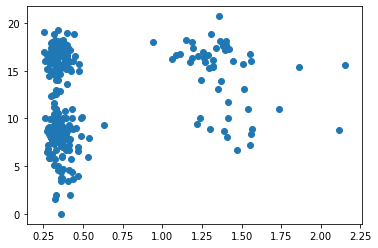

In [106]:
plt.scatter(peak_ch1, remaining_durations)

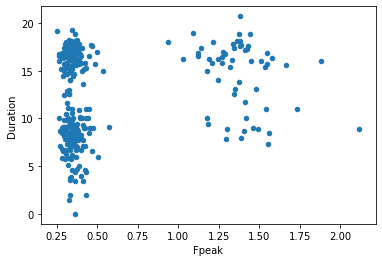

In [107]:
# Let's check if this matches the feature file

df = pd.read_csv('data/features/tpehgdb_features__filter_0.3_Hz-3.0_Hz.fvl')
df['Duration'] = df['Gestation'] - df['Rec. time']
df[df['Chann'] == 1][['Fpeak', 'Duration']].plot(kind='scatter', x='Fpeak', y='Duration')

# Median Frequency

In [104]:
def median_freq(data, fs):
    ps = np.abs(np.fft.fft(data))**2
    M = len(ps)
    freqs = np.fft.fftfreq(M, d=1/fs)
    
    mask = freqs >= 0
    freqs = freqs[mask]
    ps = ps[mask]
    
    best_k, min_dist = None, float('inf')
    
    # Divide-and-conquer on array of positive values to find
    # index that partitions the array into parts with
    # an as equal sum as possible
    k = len(ps) // 2
    offset = len(ps) // 4
    while offset > 0:
        sum1 = np.sum(ps[:k])
        sum2 = np.sum(ps[k:])
        d = abs(sum1 - sum2)
            
        if d < min_dist:
            min_dist = d
            best_k = k
        
        if sum1 > sum2:
            k -= offset
        else:
            k += offset
            
        offset = offset // 2
            
    return freqs[best_k]

med_ch1 = []
med_ch2 = []
med_ch3 = []

for (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(signals):
    cutoff = len(signal_ch1) - 32768
    signal_ch1 = signal_ch1[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    signal_ch2 = signal_ch2[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    signal_ch3 = signal_ch3[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    med_ch1.append(median_freq(signal_ch1, 20.0))
    med_ch2.append(median_freq(signal_ch2, 20.0))
    med_ch3.append(median_freq(signal_ch3, 20.0))

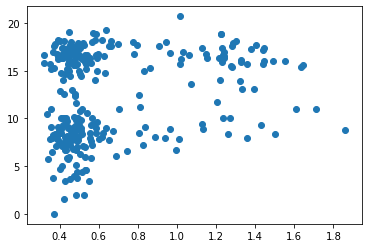

In [102]:
plt.scatter(med_ch1, remaining_durations)

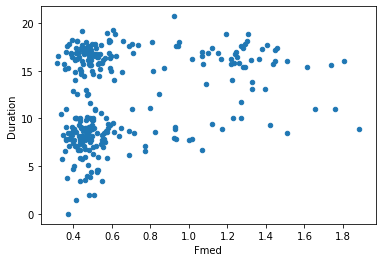

In [103]:
# Let's check if this matches the feature file

df = pd.read_csv('data/features/tpehgdb_features__filter_0.3_Hz-3.0_Hz.fvl')
df['Duration'] = df['Gestation'] - df['Rec. time']
df[df['Chann'] == 1][['Fmed', 'Duration']].plot(kind='scatter', x='Fmed', y='Duration')

# Root Mean Squared

In [29]:
def rms(signal):
    return np.sqrt(np.mean(signal[3000:-3000] ** 2)) * 1000

rms_ch1 = []
rms_ch2 = []
rms_ch3 = []

for (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(signals):
    rms_ch1.append(rms(signal_ch1))
    rms_ch2.append(rms(signal_ch2))
    rms_ch3.append(rms(signal_ch3))

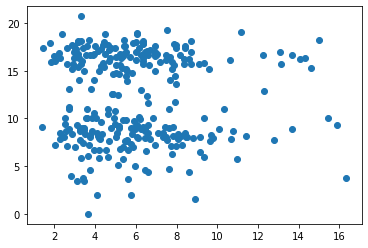

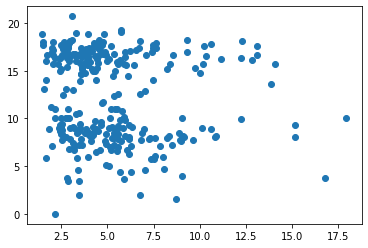

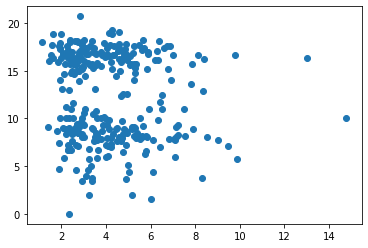

In [30]:
plt.figure()
plt.scatter(rms_ch1, remaining_durations)
plt.show()

plt.figure()
plt.scatter(rms_ch2, remaining_durations)
plt.show()

plt.figure()
plt.scatter(rms_ch3, remaining_durations)
plt.show()

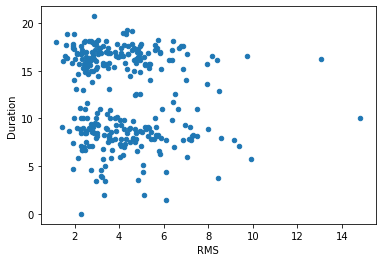

In [31]:
# Let's check if this matches the feature file

df = pd.read_csv('data/features/tpehgdb_features__filter_0.3_Hz-3.0_Hz.fvl')
df['Duration'] = df['Gestation'] - df['Rec. time']
df[df['Chann'] == 3][['RMS', 'Duration']].plot(kind='scatter', x='RMS', y='Duration')

# Sample Entropy

In [101]:
sampen_ch1 = []
sampen_ch2 = []
sampen_ch3 = []

for _id, (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(list(zip(ids, signals))):
    sampen_ch1.append(app_entropy(signal_ch1[3000:-3000], 2, r=0.15))
    print(sampen_ch1[-1])
    sampen_ch2.append(app_entropy(signal_ch2[3000:-3000], 2, r=0.15))
    sampen_ch3.append(app_entropy(signal_ch3[3000:-3000], 2, r=0.15))

0.8389493365634477
1.0831142335324637
0.920096643606362


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.scatter(sampen_ch1, remaining_durations)
plt.show()

plt.figure()
plt.scatter(sampen_ch2, remaining_durations)
plt.show()

plt.figure()
plt.scatter(sampen_ch3, remaining_durations)
plt.show()

In [ ]:
# Let's check if this matches the feature file
provided_sampen = []
df = pd.read_csv('data/features/tpehgdb_features__filter_0.3_Hz-3.0_Hz.fvl')
for _id in ids:
    provided_sampen.append(df[(df['Record'] == ' '+_id) & (df['Chann'] == 1)].iloc[0, :]['Samp. en.'])
    
plt.figure()
plt.scatter(sampen_ch1, provided_sampen)
plt.show()

# Fuzzy Sample Entropy

In [111]:
def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array
        Time series, of shape (n_times)
    order : int
        Embedding dimension (order).
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray
        Embedded time-series, of shape (n_times - (order - 1) * delay, order)
    """
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

def fuzzy_gaussian(d, r):
    return np.exp( (-d**2) / (2*r**2) )

def chebychev(x, y):
    return np.max(np.abs(x - y), axis=1)

def fuzzy_entropy(x, order):
    """Utility function for `app_entropy`` and `sample_entropy`.
    """
    phi = np.zeros(2)
    r = 0.2 * np.std(x, axis=-1, ddof=1)

    # Step 1: Form ( N − n ) composite delay vectors
    _emb_data1 = _embed(x, order, 1)
    
    # Step 2: Remove local mean
    _emb_data1 -= np.mean(_emb_data1, axis=0)
    
    # Step 3 & 4: Calculate B^m(r)
    B_m = np.mean([np.mean(fuzzy_gaussian(chebychev(_emb_data1[i], _emb_data1), r)) for i in range(len(_emb_data1))])

    # Step 5-7: Do the same for B^(M+1)
    _emb_data2 = _embed(x, order + 1, 1)
    
    # Step 2: Remove local mean
    _emb_data2 -= np.mean(_emb_data2, axis=0)
    
    # Step 3 & 4: Calculate B^m(r)
    B_m1 = np.mean([np.mean(fuzzy_gaussian(chebychev(_emb_data2[i], _emb_data2), r)) for i in range(len(_emb_data2))])

    return -np.log(B_m1 / B_m)

In [113]:
fuzzy_entropy(signals[0][0], 2)

0.13712661150741162 0.19056832255882777


0.329106108239052

# Autocorrelation zero-crossing

In [22]:
import statsmodels.api as sm

def ac_zero_crossing(signal):
    tau = sm.tsa.acf(signal, nlags=len(signal) - 1)
    tau_neg_ix = np.arange(len(tau), dtype=int)[tau < 0]
    return tau_neg_ix[0]

ac_zero_ch1 = []
ac_zero_ch2 = []
ac_zero_ch3 = []

for _id, (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(list(zip(ids, signals))):
#     print(ac_zero_crossing(signal_ch1[3000:-3000]), Tao(signal_ch1[3000:-3000]))
    ac_zero_ch1.append(ac_zero_crossing(signal_ch1[3000:-3000]))
    ac_zero_ch2.append(ac_zero_crossing(signal_ch2[3000:-3000]))
    ac_zero_ch3.append(ac_zero_crossing(signal_ch3[3000:-3000]))

KeyboardInterrupt: 

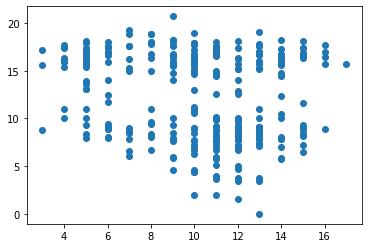

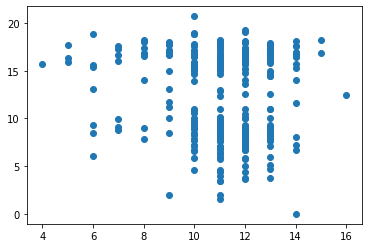

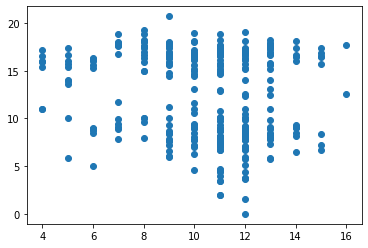

In [8]:
plt.figure()
plt.scatter(ac_zero_ch1, remaining_durations)
plt.show()

plt.figure()
plt.scatter(ac_zero_ch2, remaining_durations)
plt.show()

plt.figure()
plt.scatter(ac_zero_ch3, remaining_durations)
plt.show()

# Maximal Lyapunov Exponent (Rosenstein algorithm)

In [67]:
# # Warning: very memory-intensive (and untested)

from nolitsa.lyapunov import mle_embed
lyap_ch1 = []

for i, (_id, (signal_ch1, signal_ch2, signal_ch3)) in tqdm_notebook(enumerate(list(zip(ids, signals)))):
    y = mle_embed(signal_ch1[3000:-3000], [7], ac_zero_ch1[i], maxt=10)[0]
    x = np.arange(len(y))
    
    lyap_ch1.append(np.polyfit(x, y, 1)[0])
    
    if i == 50:
        break

# from nolds import lyap_r

# lyap_ch1 = []
# lyap_ch2 = []
# lyap_ch3 = []

# for i, (_id, (signal_ch1, signal_ch2, signal_ch3)) in tqdm_notebook(enumerate(list(zip(ids, signals)))):
#     lyap_ch1.append(lyap_r(signal_ch1[3000:-3000], emb_dim=7, lag=ac_zero_ch1[i]))
# #     lyap_ch2.append(lyap_r(signal_ch2[3000:-3000], emb_dim=7))
# #     lyap_ch3.append(lyap_r(signal_ch3[3000:-3000], emb_dim=7))

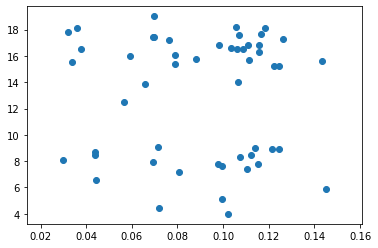

In [69]:
plt.scatter(lyap_ch1, remaining_durations[:len(lyap_ch1)])

In [75]:
from scipy.stats import ttest_ind

preterm_early = []
preterm_late = []
term_early = []
term_late = []
for gest, dur, lyap in zip(gestations, remaining_durations, lyap_ch1):
    if gest - dur <= 26:
        if gest >= 37:
            term_early.append(lyap)
        else:
            preterm_early.append(lyap)
    else:
        if gest >= 37:
            term_late.append(lyap)
        else:
            preterm_late.append(lyap)
        
print(term_early, preterm_early)
# print(preterm_early, preterm_late)
print(ttest_ind(preterm_early, term_early))
print(ttest_ind(preterm_late, term_late))

[0.07636514121070026, 0.03753511398971444, 0.11664880991674756, 0.11574228511630294, 0.1155161656178812, 0.122099320024579, 0.07874904688085868, 0.11821316283950492, 0.06935200581700789, 0.03583276107209364, 0.07904565280227613, 0.10326053861388455, 0.10686090936957286, 0.06557340738083876, 0.10617301437438599, 0.10572641187713881, 0.10660909027242546, 0.03217646810131801, 0.09835845604979321, 0.1086106623916583, 0.06983710662317956, 0.14329808359400384, 0.12609170056909935, 0.12442956146377533, 0.111448374818167, 0.11080055683918429, 0.06957744704696915, 0.05940640356203463, 0.033963199185111245, 0.08806569255551784] [0.056678753409447245]
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=1.0182574685644485, pvalue=0.32204764092907423)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


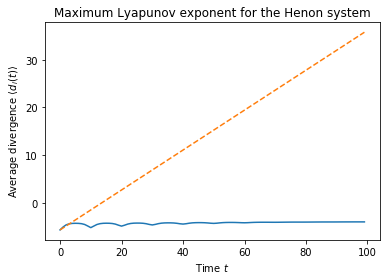

In [57]:
from nolitsa import data, lyapunov
import numpy as np
import matplotlib.pyplot as plt

x = data.henon(length=5000)[:, 0]

# Time delay.
tau = 1

# Embedding dimension.
dim = [2]

d = lyapunov.mle_embed(signals[0][0][3000:-3000], [7], ac_zero_ch1[0], maxt=100)[0]
t = np.arange(100)

plt.title('Maximum Lyapunov exponent for the Henon system')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.plot(t, d)
plt.plot(t, t * 0.419 + d[0], '--')

plt.show()

In [66]:
d, [-4.6353 + 0.00746983 * i for i in range(len(d))]

(array([-5.6933378 , -5.07687887, -4.62621846, -4.4136014 , -4.32676548,
        -4.30455226, -4.31970012, -4.38715393, -4.55070124, -4.86914167,
        -5.21385101, -4.87879598, -4.55481577, -4.38220785, -4.3073089 ,
        -4.28620795, -4.29663252, -4.34930492, -4.47474067, -4.6987408 ,
        -4.89639438, -4.70344734, -4.47312709, -4.33744615, -4.27636738,
        -4.25815927, -4.26447889, -4.30173728, -4.39116753, -4.5392661 ,
        -4.64965372, -4.53410337, -4.37696353, -4.27515781, -4.22651227,
        -4.21045296, -4.21489258, -4.24233688, -4.30552808, -4.40252817,
        -4.46549391, -4.39614919, -4.28897957, -4.2138906 , -4.17726028,
        -4.16464146, -4.16786521, -4.18751615, -4.22951177, -4.28841652,
        -4.3223096 , -4.28173589, -4.21347203, -4.16173524, -4.1345971 ,
        -4.12375852, -4.1235561 , -4.13263234, -4.15365542, -4.1810184 ,
        -4.1951181 , -4.17609025, -4.14113638, -4.11186794, -4.09496346,
        -4.08614116, -4.0828768 , -4.08263369, -4.0

In [60]:
np.polyfit(np.arange(len(d)), d, 1)

array([ 0.00746983, -4.63537716])

# Correlation dimension

In [43]:
from nolitsa.d2 import c2_embed, d2

corr_ch1 = []
corr_ch2 = []
corr_ch3 = []

for i, (_id, (signal_ch1, signal_ch2, signal_ch3)) in tqdm_notebook(enumerate(list(zip(ids, signals)))):
    r, C_r = c2_embed(signal_ch1[3000:-3000], [7], ac_zero_ch1[i])[0]
    print(r[:7], C_r[:7])
    corr_ch1.append(d2(r[:7], C_r[:7])[0])
    if i == 10:
        break
#     corr_ch1.append(Dim_Corr(signal_ch1[3000:-3000], ac_zero_ch1[0], 7))
#     corr_ch2.append(corr_dim(signal_ch2[3000:-3000], 7))
#     corr_ch3.append(corr_dim(signal_ch3[3000:-3000], 7))

[0.00024386 0.00026149 0.00028038 0.00030065 0.00032237 0.00034567
 0.00037065] [4.68184702e-09 4.68184702e-09 4.68184702e-09 4.68184702e-09
 4.68184702e-09 4.68184702e-09 4.68184702e-09]


/usr/local/lib/python3.6/dist-packages/nolitsa/d2.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  d[i] = np.linalg.lstsq(A, q)[0][0]


[0.00053963 0.00057863 0.00062044 0.00066528 0.00071336 0.00076491
 0.00082019] [1.17318949e-08 1.17318949e-08 3.98884428e-08 3.98884428e-08
 9.85479176e-08 2.34637899e-07 2.34637899e-07]
[0.0004781  0.00051266 0.0005497  0.00058943 0.00063203 0.0006777
 0.00072668] [2.23808442e-09 2.23808442e-09 2.23808442e-09 2.23808442e-09
 4.47616883e-09 4.47616883e-09 4.47616883e-09]
[0.00031649 0.00033936 0.00036389 0.00039018 0.00041838 0.00044862
 0.00048104] [6.70617474e-09 6.70617474e-09 6.70617474e-09 1.34123495e-08
 1.34123495e-08 1.34123495e-08 6.70617474e-08]
[0.00031574 0.00033856 0.00036302 0.00038926 0.00041739 0.00044755
 0.0004799 ] [8.94874506e-09 8.94874506e-09 8.94874506e-09 4.02693528e-08
 4.02693528e-08 4.02693528e-08 9.39618231e-08]


Process ForkPoolWorker-149:
Process ForkPoolWorker-151:
Process ForkPoolWorker-152:
Process ForkPoolWorker-150:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", l

KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.6/dist-packages/nolitsa/d2.py", line 95, in c2
    c += np.histogram(dists, bins=bins)[0]
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py", line 795, in histogram
    sa = np.sort(a[i:i+BLOCK])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py", line 878, in sort
    a.sort(axis=axis, kind=kind, order=order)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-153:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 25

In [68]:
corr_ch1

[array([6.10611864e-15]),
 array([8.1297272]),
 array([2.12871211]),
 array([4.60007034]),
 array([5.92020641])]

In [5]:
def logarithmic_r(min_n, max_n, factor):
    """
    Creates a list of values by successively multiplying a minimum value min_n by
    a factor > 1 until a maximum value max_n is reached.

    Args:
    min_n (float):
      minimum value (must be < max_n)
    max_n (float):
      maximum value (must be > min_n)
    factor (float):
      factor used to increase min_n (must be > 1)

    Returns:
    list of floats:
      min_n, min_n * factor, min_n * factor^2, ... min_n * factor^i < max_n
    """
    assert max_n > min_n
    assert factor > 1
    max_i = int(np.floor(np.log(1.0 * max_n / min_n) / np.log(factor)))
    return [min_n * (factor ** i) for i in range(max_i + 1)]

sd = np.std(signals[0][0][3000:-3000])
print(sd)
logarithmic_r(0.1 * sd, 0.5 * sd, 1.03)

0.006361917483843214


[0.0006361917483843215,
 0.0006552775008358511,
 0.0006749358258609266,
 0.0006951839006367545,
 0.0007160394176558572,
 0.0007375206001855329,
 0.0007596462181910989,
 0.0007824356047368318,
 0.0008059086728789369,
 0.000830085933065305,
 0.0008549885110572641,
 0.000880638166388982,
 0.0009070573113806515,
 0.0009342690307220711,
 0.0009622971016437333,
 0.0009911660146930453,
 0.0010209009951338368,
 0.0010515280249878518,
 0.0010830738657374875,
 0.001115566081709612,
 0.0011490330641609006,
 0.0011835040560857276,
 0.0012190091777682993,
 0.0012555794531013485,
 0.001293246836694389,
 0.0013320442417952205,
 0.0013720055690490773,
 0.0014131657361205498,
 0.0014555607082041662,
 0.0014992275294502912,
 0.0015442043553338,
 0.0015905304859938137,
 0.0016382464005736284,
 0.0016873937925908373,
 0.0017380156063685622,
 0.0017901560745596193,
 0.001843860756796408,
 0.0018991765795003002,
 0.0019561518768853093,
 0.0020148364331918685,
 0.0020752815261876247,
 0.0021375399719732536,


# Features from "Advanced Artificial Neural Network Classification for Detecting Preterm BirthsUsing EHG Records"

In [ ]:
def sum_absolute_values(signal):
    return np.sum(np.abs(signal))

def mean_abs_value(signal):
    return np.mean(np.abs(signal))

def squared_sum(signal):
    return np.sum(signal)

def wavelet_length(signal):
    return np.sum(np.abs(signal[:-1] - signal[1:]))

def log_detector(signal):
    return np.exp(np.mean(np.log(np.abs(signal))))

def variance(signal):
    return np.var(signal)

def variance_abs(signal):
    return np.var(np.abs(np.power(signal[:-1] - signal[1:], 2)))

def max_fractal_length(signal):
    return np.log(np.sqrt(np.sum(np.power(signal[:-1] - signal[1:], 2))))

def avg_amplitude_change(signal):
    return np.mean(np.abs(signal[:-1] - signal[1:]))